## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96-aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_3.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_4.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux/fold_5.tar.gz

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_valid_mask.npy
fold_1/y_valid_aux.npy
fold_1/x_valid.npy
fold_1/x_train.npy
fold_1/x_valid_aux.npy
fold_1/y_train.npy
fold_1/x_valid_aux2.npy
fold_1/x_train_aux2.npy
fold_1/y_train_mask.npy
fold_1/y_train_aux.npy
fold_1/x_train_aux.npy
fold_1/y_valid.npy
fold_2/
fold_2/y_valid_mask.npy
fold_2/y_valid_aux.npy
fold_2/x_valid.npy
fold_2/x_train.npy
fold_2/x_valid_aux.npy
fold_2/y_train.npy
fold_2/x_valid_aux2.npy
fold_2/x_train_aux2.npy
fold_2/y_train_mask.npy
fold_2/y_train_aux.npy
fold_2/x_train_aux.npy
fold_2/y_valid.npy
fold_3/
fold_3/y_valid_mask.npy
fold_3/y_valid_aux.npy
fold_3/x_valid.npy
fold_3/x_train.npy
fold_3/x_valid_aux.npy
fold_3/y_train.npy
fold_3/x_valid_aux2.npy
fold_3/x_train_aux2.npy
fold_3/y_train_mask.npy
fold_3/y_train_aux.npy
fold_3/x_train_aux.npy
fold_3/y_valid.npy
fold_4/
fold_4/y_valid_mask.npy
fold_4/y_valid_aux.npy
fold_4/x_valid.npy
fold_4/x_train.npy
fold_4/x_valid_aux.npy
fold_4/y_train.npy
fold_4/x_valid_aux2.npy
fold_4/x_train_aux2.npy
f

# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 96,
  'BATCH_SIZE': 32,
  'EPOCHS': 5,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 1,
  'question_size': 4,
  'N_FOLDS': 5,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [4]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


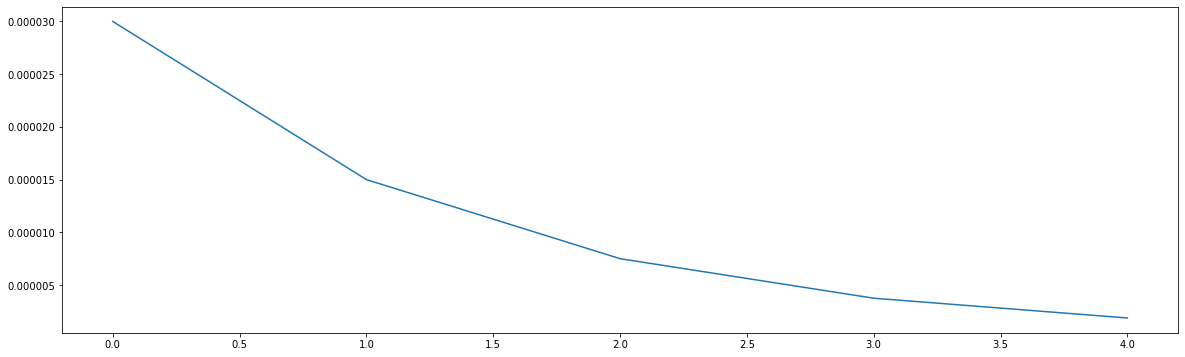

In [5]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    x_mask = layers.Dropout(.1)(last_hidden_state) 
    x_mask = layers.Dense(1)(x_mask)
    x_mask = layers.Flatten()(x_mask)
    y_mask = layers.Activation('sigmoid', name='y_mask')(x_mask)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end, y_mask])
    
    return model

# Train

In [7]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0],'attention_mask': x_train[1]}, 
                                                  {'y_start': y_train[0],'y_end': y_train[1],'y_mask': y_train[2]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0],'attention_mask': x_valid[1]}, 
                                                  {'y_start': y_valid[0],'y_end': y_valid[1],'y_mask': y_valid[2]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    y_train_mask = np.load(base_data_path + 'y_train_mask.npy')
    y_valid_mask = np.load(base_data_path + 'y_valid_mask.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, (*y_train, y_train_mask), config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, (*y_valid, y_valid_mask), config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss_mask = loss_fn_mask(y['y_mask'], probabilities[2])
                loss = tf.math.add(loss_start, loss_end)
                loss = tf.math.add(loss, loss_mask)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
            train_loss_mask.update_state(loss_mask)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss_mask = loss_fn_mask(y['y_mask'], probabilities[2])
            loss = tf.math.add(loss_start, loss_end)
            loss = tf.math.add(loss, loss_mask)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
            valid_loss_mask.update_state(loss_mask)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy
    loss_fn_mask = losses.binary_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
    train_loss_mask = metrics.Sum()
    valid_loss_mask = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 
                    'loss_end': train_loss_end, 'loss_mask': train_loss_mask, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 
                    'val_loss_end': valid_loss_end, 'val_loss_mask': valid_loss_mask}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], model_path)
    
    history_list.append(history)
    model.load_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/5
time: 281.5s loss: 4.4892 loss_start: 2.1914 loss_end: 2.2065 loss_mask: 0.0913 val_loss: 1.9901 val_loss_start: 1.0017 val_loss_end: 0.9222 val_loss_mask: 0.0663
Saved model weights at "model_fold_1.h5"

EPOCH 2/5
time: 266.9s loss: 4.0526 loss_start: 2.0140 loss_end: 1.9727 loss_mask: 0.0659 val_loss: 1.9450 val_loss_start: 0.9876 val_loss_end: 0.8922 val_loss_mask: 0.0651
Saved model weights at "model_fold_1.h5"

EPOCH 3/5
time: 267.0s loss: 3.9424 loss_start: 1.9576 loss_end: 1.9228 loss_mask: 0.0620 val_loss: 1.9141 val_loss_start: 0.9525 val_loss_end: 0.9006 val_loss_mask: 0.0609
Saved model weights at "model_fold_1.h5"

EPOCH 4/5
time: 267.1s loss: 3.8764 loss_start: 1.9310 loss_end: 1.8854 loss_mask: 0.0600 val_loss: 1.9125 val_loss_start: 0.9623 val_loss_end: 0.8881 val_loss_mask: 0.0621
Saved model weights at "model_fold_1.h5"

EPOCH 5/5
time: 267.1s loss: 3.8370 loss_start: 1.9119 loss_end: 1.8659 loss_mask: 0.0

# Model loss graph

Fold: 1


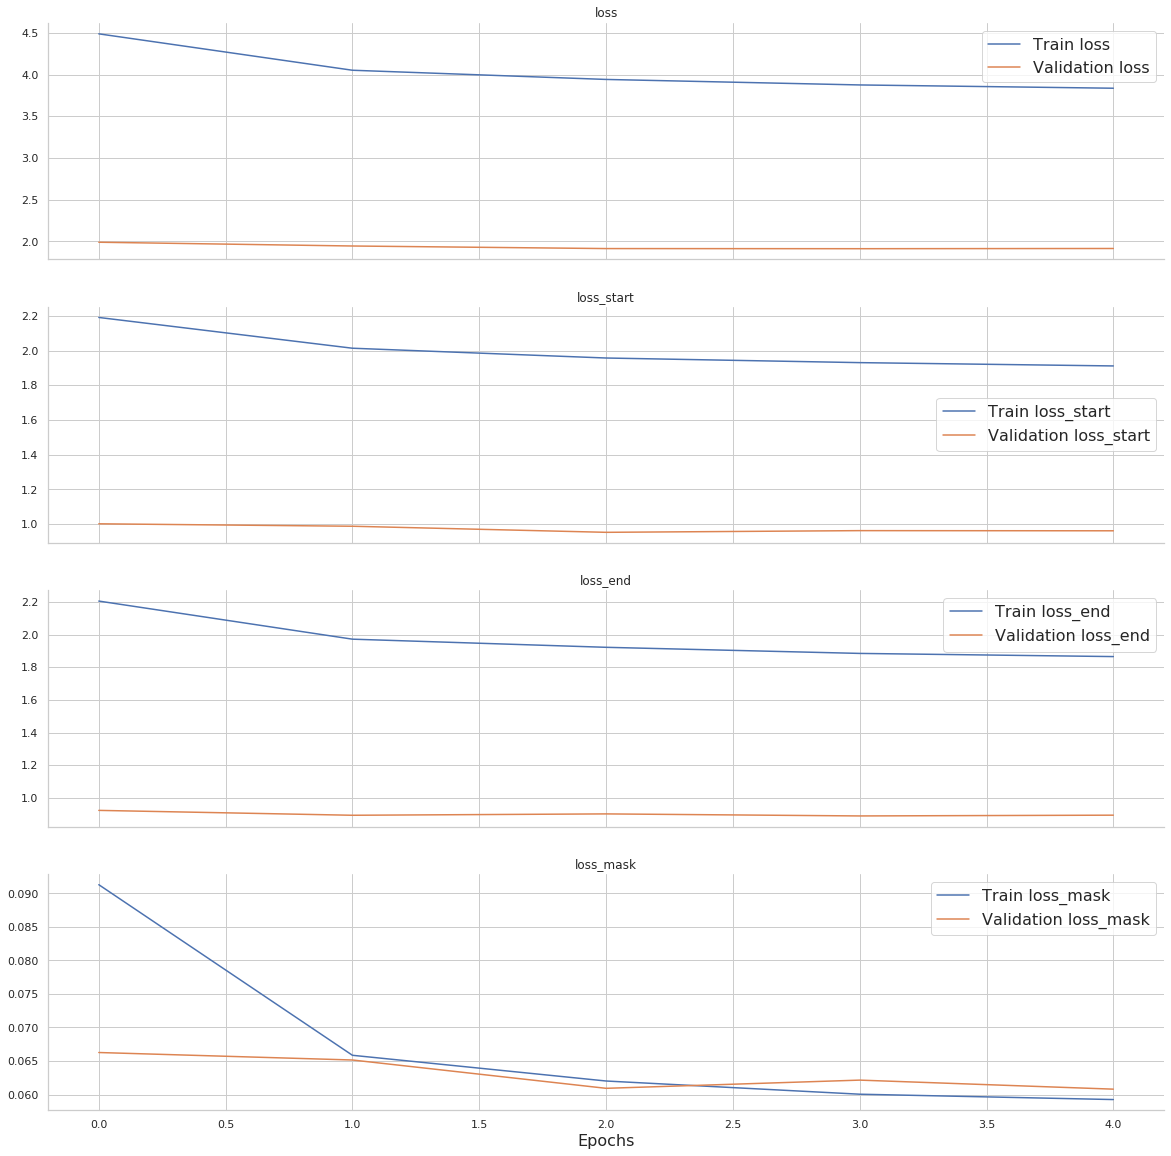

Fold: 2


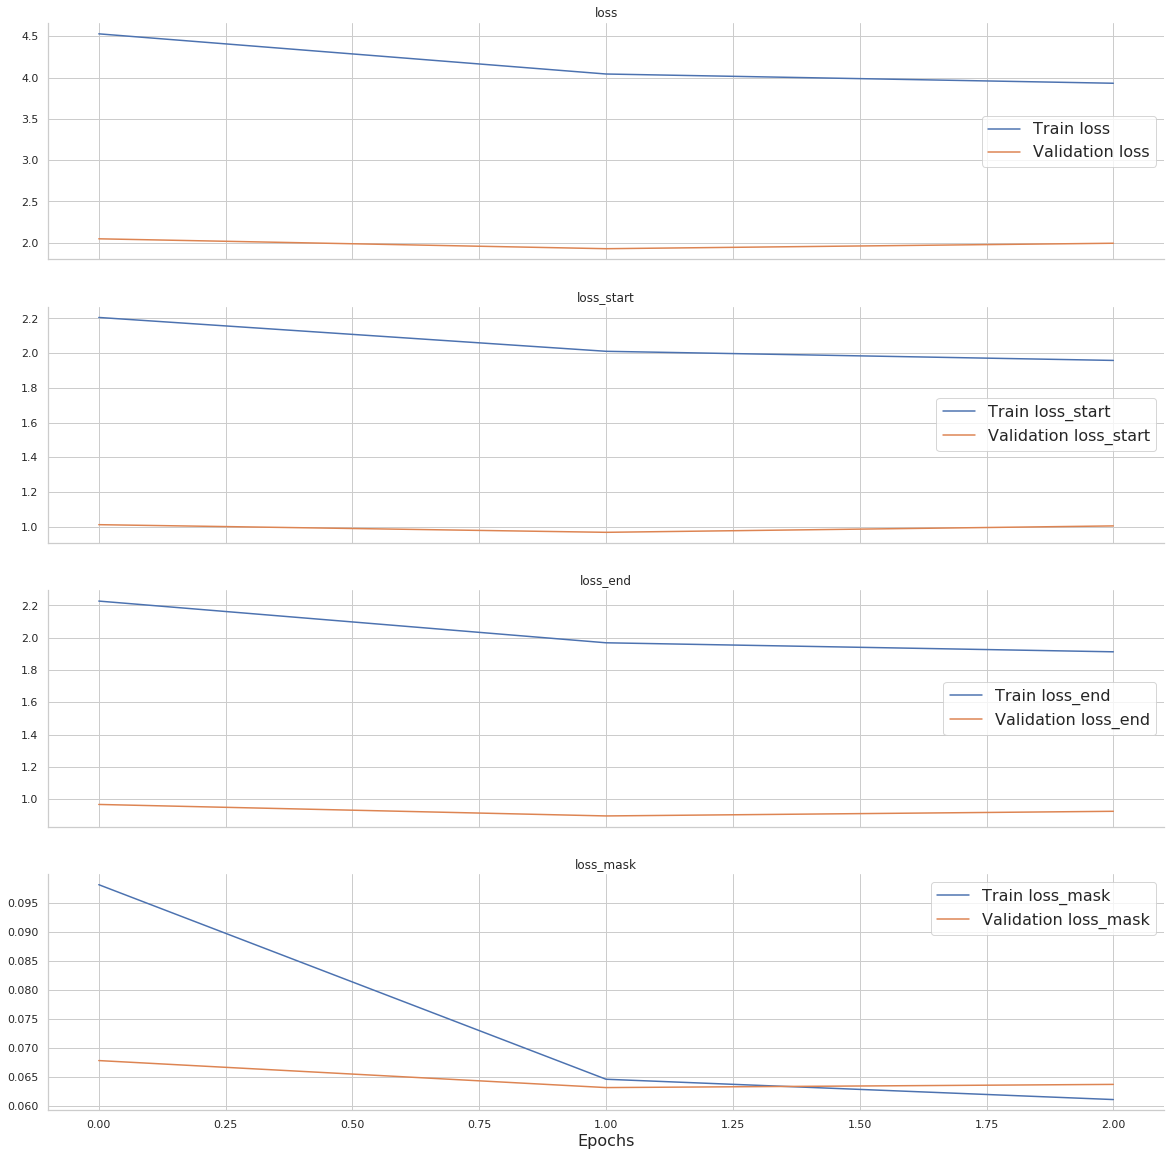

Fold: 3


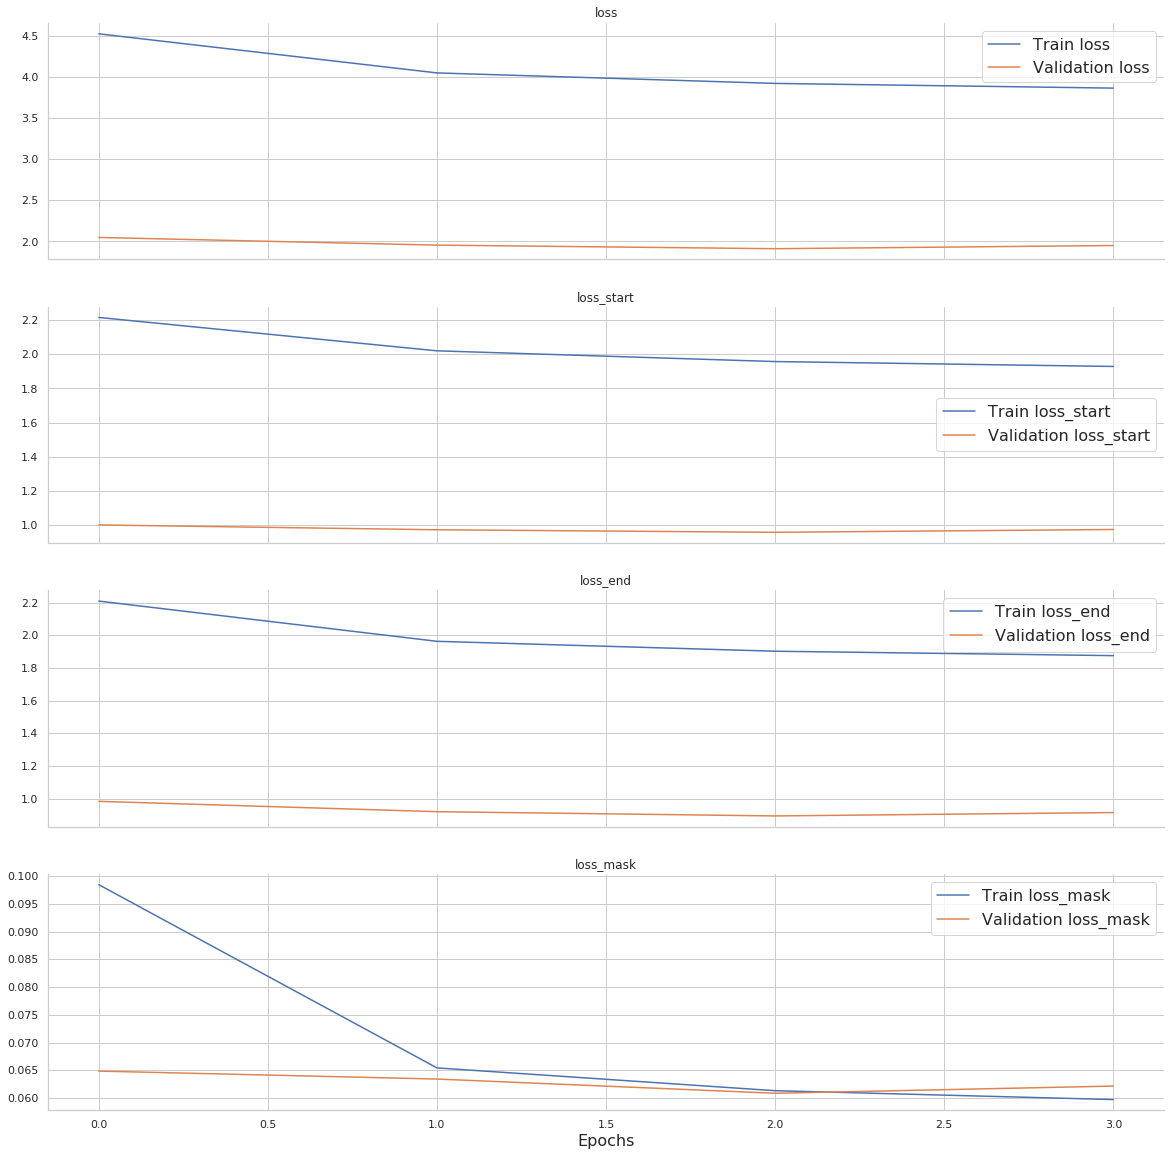

Fold: 4


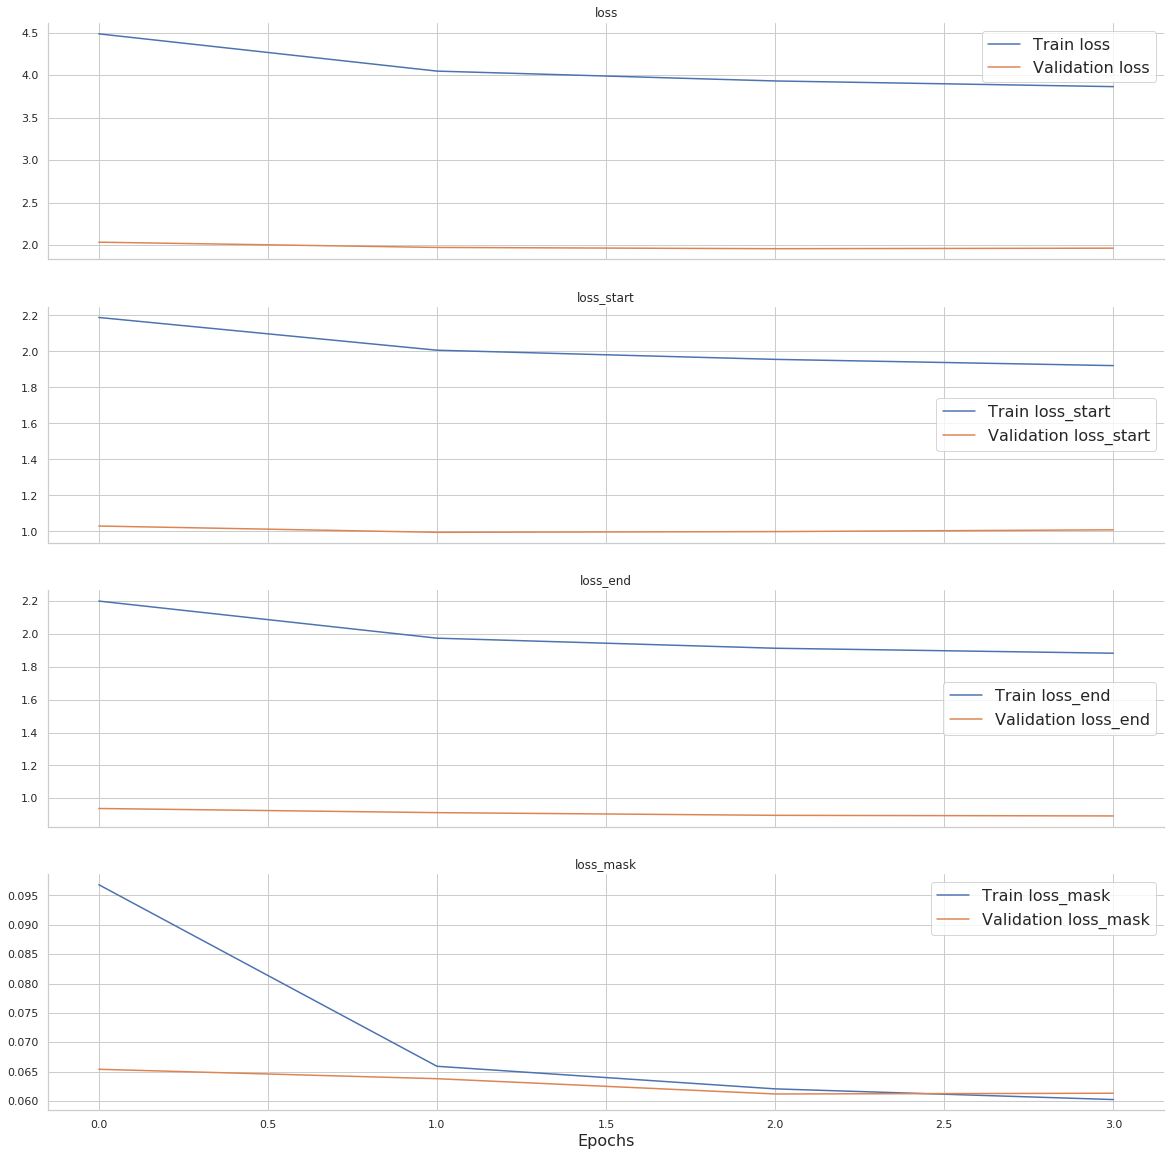

Fold: 5


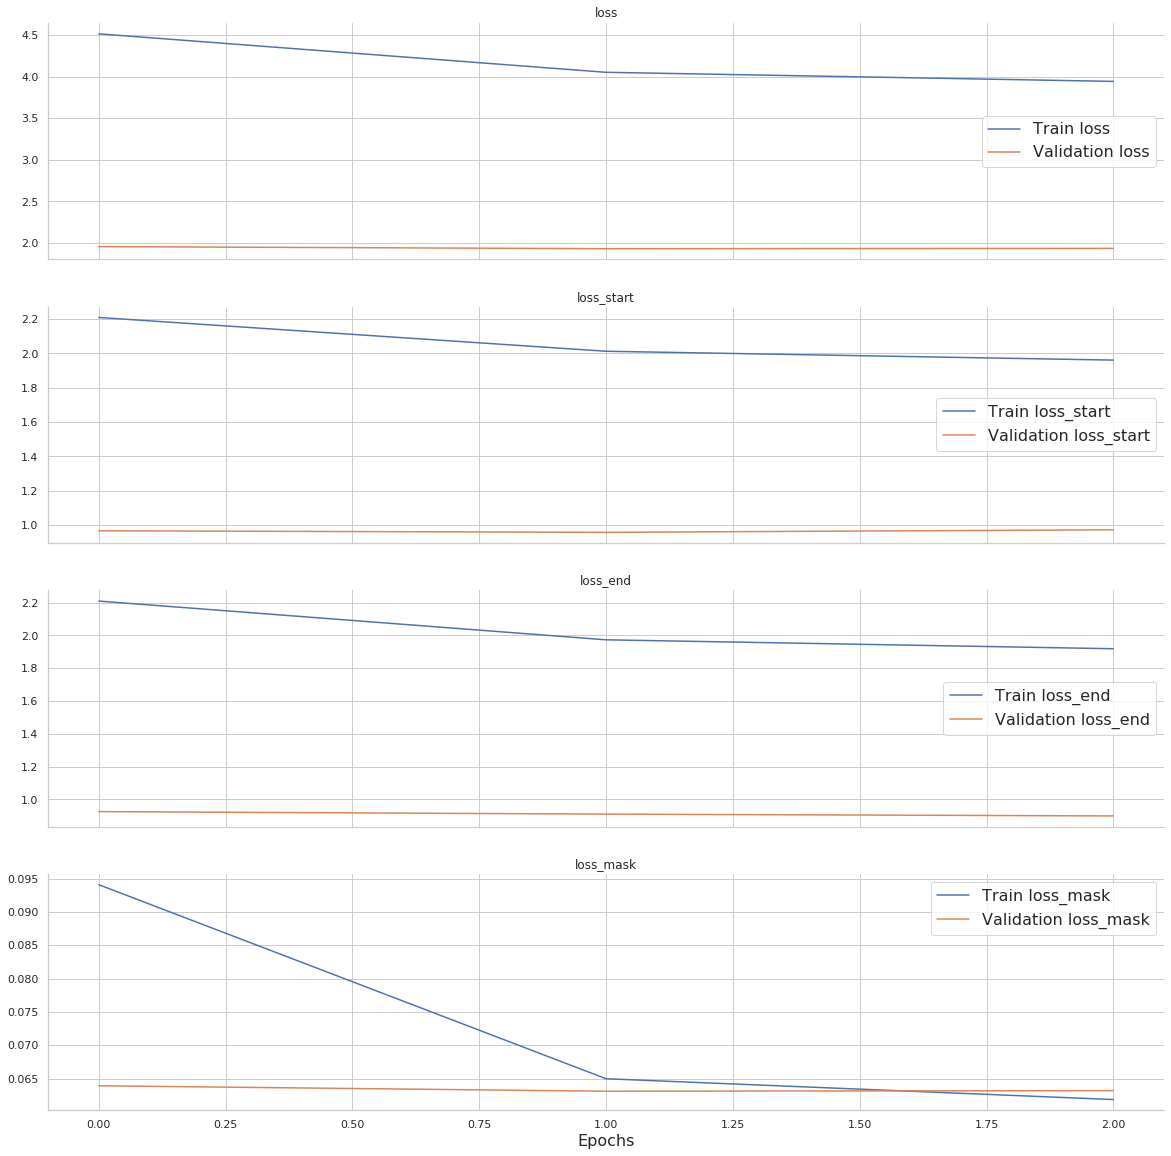

In [9]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [10]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.746811,0.705188,0.041623,0.762109,0.708526,0.734984,0.696436,0.748039,0.714311,0.751978,0.697652,0.736946,0.709014
Sentiment negative,0.600113,0.523159,0.076954,0.630381,0.516450,0.577490,0.505749,0.604045,0.540554,0.608517,0.524313,0.580130,0.528726
Sentiment neutral,0.974174,0.972804,0.001369,0.974392,0.973230,0.973591,0.972660,0.974024,0.974466,0.974935,0.970608,0.973927,0.973059
Sentiment positive,0.585295,0.523561,0.061734,0.606586,0.539628,0.568724,0.511346,0.585834,0.534949,0.593211,0.501343,0.572120,0.530539
0 <= text wordCnt < 3,0.863962,0.854092,0.009869,0.875583,0.817164,0.853754,0.859823,0.861543,0.871391,0.872121,0.834402,0.856808,0.887681
3 <= text wordCnt < 10,0.797300,0.764842,0.032458,0.809971,0.760916,0.788713,0.764810,0.797958,0.772857,0.801176,0.754089,0.788683,0.771535
10 <= text wordCnt < 30,0.715822,0.668192,0.047630,0.732842,0.675489,0.701766,0.656664,0.717045,0.679336,0.722249,0.661639,0.705210,0.667832
30 <= text wordCnt < 100,0.681309,0.628957,0.052352,0.695243,0.700743,0.695003,0.496888,0.697753,0.593610,0.651806,0.590331,0.666740,0.763211
0 <= selected text wordCnt < 3,0.681835,0.608334,0.073500,0.699504,0.603282,0.665216,0.601111,0.682195,0.615553,0.689999,0.593890,0.672260,0.627836


# Visualize predictions

In [11]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,wow...,0.200000,wow...,0.200000,wow...,0.200000,wow...,0.200000,wow...,0.200000
